# ADS 509 Assignment 5.1: Topic Modeling

This notebook holds Assignment 5.1 for Module 5 in ADS 509, Applied Text Mining. Work through this notebook, writing code and answering questions where required. 

In this assignment you will work with a categorical corpus that accompanies `nltk`. You will build the three types of topic models described in Chapter 8 of _Blueprints for Text Analytics using Python_: NMF, LSA, and LDA. You will compare these models to the true categories. 


## General Assignment Instructions

These instructions are included in every assignment, to remind you of the coding standards for the class. Feel free to delete this cell after reading it. 

One sign of mature code is conforming to a style guide. We recommend the [Google Python Style Guide](https://google.github.io/styleguide/pyguide.html). If you use a different style guide, please include a cell with a link. 

Your code should be relatively easy-to-read, sensibly commented, and clean. Writing code is a messy process, so please be sure to edit your final submission. Remove any cells that are not needed or parts of cells that contain unnecessary code. Remove inessential `import` statements and make sure that all such statements are moved into the designated cell. 

Make use of non-code cells for written commentary. These cells should be grammatical and clearly written. In some of these cells you will have questions to answer. The questions will be marked by a "Q:" and will have a corresponding "A:" spot for you. *Make sure to answer every question marked with a `Q:` for full credit.* 


In [1]:
#!python -m spacy download en_core_web_sm
#python --version


In [2]:
# These libraries may be useful to you

#!pip install pyLDAvis==3.4.1 --user  #You need to restart the Kernel after installation.
# You also need a Python version => 3.9.0
from nltk.corpus import brown

import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import pyLDAvis
import pyLDAvis.lda_model
import pyLDAvis.gensim_models

import spacy
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.decomposition import NMF, TruncatedSVD, LatentDirichletAllocation

from spacy.lang.en.stop_words import STOP_WORDS as stopwords

from collections import Counter, defaultdict

nlp = spacy.load('en_core_web_sm')

In [3]:
# add any additional libaries you need here



In [4]:
# This function comes from the BTAP repo.

def display_topics(model, features, no_top_words=5):
    for topic, words in enumerate(model.components_):
        total = words.sum()
        largest = words.argsort()[::-1] # invert sort order
        print("\nTopic %02d" % topic)
        for i in range(0, no_top_words):
            print("  %s (%2.2f)" % (features[largest[i]], abs(words[largest[i]]*100.0/total)))

## Getting to Know the Brown Corpus

Let's spend a bit of time getting to know what's in the Brown corpus, our NLTK example of an "overlapping" corpus.

In [5]:
# categories of articles in Brown corpus
for category in brown.categories() :
    print(f"For {category} we have {len(brown.fileids(categories=category))} articles.")

For adventure we have 29 articles.
For belles_lettres we have 75 articles.
For editorial we have 27 articles.
For fiction we have 29 articles.
For government we have 30 articles.
For hobbies we have 36 articles.
For humor we have 9 articles.
For learned we have 80 articles.
For lore we have 48 articles.
For mystery we have 24 articles.
For news we have 44 articles.
For religion we have 17 articles.
For reviews we have 17 articles.
For romance we have 29 articles.
For science_fiction we have 6 articles.


Let's create a dataframe of the articles in of hobbies, editorial, government, news, and romance.

In [6]:
categories = ['editorial','government','news','romance','hobbies'] 

category_list = []
file_ids = []
texts = []

for category in categories : 
    for file_id in brown.fileids(categories=category) :
        
        # build some lists for a dataframe
        category_list.append(category)
        file_ids.append(file_id)
        
        text = brown.words(fileids=file_id)
        texts.append(" ".join(text))

        
        
df = pd.DataFrame()
df['category'] = category_list
df['id'] = file_ids
df['text'] = texts 

df.shape

(166, 3)

In [7]:
# Let's add some helpful columns on the df
df['char_len'] = df['text'].apply(len)
df['word_len'] = df['text'].apply(lambda x: len(x.split()))


<AxesSubplot: xlabel='category'>

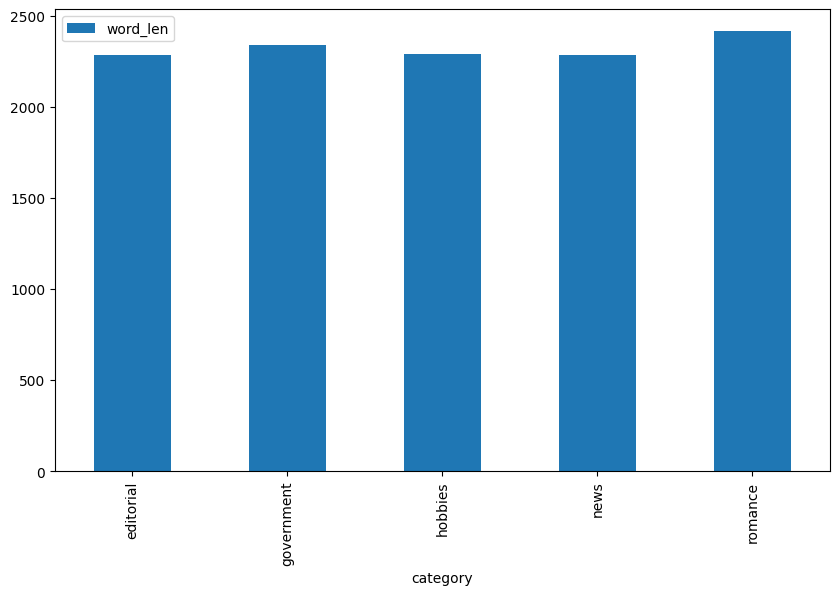

In [8]:
%matplotlib inline
df.groupby('category').agg({'word_len': 'mean'}).plot.bar(figsize=(10,6))

Now do our TF-IDF and Count vectorizations.

In [9]:
count_text_vectorizer = CountVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
count_text_vectors = count_text_vectorizer.fit_transform(df["text"])
count_text_vectors.shape

/Library/Frameworks/Python.framework/Versions/3.11/lib/python3.11/site-packages/sklearn/feature_extraction/text.py:409: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['ll', 've'] not in stop_words.
  warnings.warn(


(166, 4941)

In [10]:
tfidf_text_vectorizer = TfidfVectorizer(stop_words=list(stopwords), min_df=5, max_df=0.7)
tfidf_text_vectors = tfidf_text_vectorizer.fit_transform(df['text'])
tfidf_text_vectors.shape

(166, 4941)

Q: What do the two data frames `count_text_vectors` and `tfidf_text_vectors` hold? 

A: The two matrices hold the text data that was transformed using the CountVectorizer() and TfidfVectorizer() functions. Each contain the token frequencies (count_text_vectors) or the TF-IDF scores (tfidf_text_vectors) of the text column of the Brown corpus. These frequencies or scores are the unique words (tokens) with the stop words removed. The two allow us to observe a unique word (4941, columns) and its frequencies relevant for each document/text (166, rows).

## Fitting a Non-Negative Matrix Factorization Model

In this section the code to fit a five-topic NMF model has already been written. This code comes directly from the [BTAP repo](https://github.com/blueprints-for-text-analytics-python/blueprints-text), which will help you tremendously in the coming sections. 

In [11]:
nmf_text_model = NMF(n_components=5, random_state=314)
W_text_matrix = nmf_text_model.fit_transform(tfidf_text_vectors)
H_text_matrix = nmf_text_model.components_

In [12]:
display_topics(nmf_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  mr (0.51)
  president (0.45)
  kennedy (0.43)
  united (0.42)
  khrushchev (0.40)

Topic 01
  said (0.88)
  didn (0.46)
  ll (0.45)
  thought (0.42)
  man (0.37)

Topic 02
  state (0.39)
  development (0.36)
  tax (0.33)
  sales (0.30)
  program (0.25)

Topic 03
  mrs (2.61)
  mr (0.78)
  said (0.63)
  miss (0.52)
  car (0.51)

Topic 04
  game (1.02)
  league (0.74)
  ball (0.72)
  baseball (0.71)
  team (0.66)


Now some work for you to do. Compare the NMF factorization to the original categories from the Brown Corpus.

We are interested in the extent to which our NMF factorization agrees or disagrees with the original categories in the corpus. For each topic in your NMF model, tally the Brown categories and interpret the results. 


In [13]:
nmf_results_df = pd.DataFrame(W_text_matrix, columns=["Topic 0", "Topic 1", "Topic 2", "Topic 3", "Topic 4"])
nmf_results_df["Original Category"] = df["category"]


In [14]:
nmf_topic_totals = nmf_results_df.groupby("Original Category").sum()
nmf_topic_totals

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4
Original Category,,,,,
editorial,4.420816,1.369007,1.517259,0.382334,0.566543
government,1.219534,0.141536,5.767501,0.284375,0.093458
hobbies,0.354584,1.977154,4.828017,0.468127,1.040443
news,3.350652,1.093574,3.178343,5.524152,4.203588
romance,0.183783,8.971569,0.189448,0.827248,0.399900


In [18]:
# Let's go document by document and make a list of brown categories by topic
topic_to_category = defaultdict(list)

for idx, row in enumerate(W_text_matrix) : 
    topic = np.where(row == np.amax(row))[0]
    category = df["category"].iloc[idx]
    
    topic_to_category[topic[0]].append(category)

In [19]:
topic_counts = {topic: Counter(category) for topic, category in topic_to_category.items()}

# Iterate over topics and categories
for topic, count in topic_counts.items():
    print(f"\nTopic {topic}:")
    for category, category_count in count.items():
        print(f"  {category}: {category_count}")



Topic 2:
  editorial: 2
  government: 26
  news: 11
  hobbies: 26

Topic 0:
  editorial: 20
  government: 4
  news: 8

Topic 1:
  editorial: 4
  romance: 29
  hobbies: 8

Topic 4:
  editorial: 1
  news: 8
  hobbies: 1

Topic 3:
  news: 17
  hobbies: 1


Q: How does your five-topic NMF model compare to the original Brown categories? 

A: With the five topic NMF model, Topic 2 had the same number of iterations for 'government' and 'hobbies. Topic 0 had a strong association to 'editorial'. Topic 1 resulted with a higher count to 'romance'. Topic 4, had low iterations but more towards 'news'. Lastly, Topic 3 had a stronger association to 'news. 

- Topic 0: 'editorial'
- Topic 1: 'romance'
- Topic 2: 'government' and 'hobbies'
- Topic 3: 'news'
- Topic 4: 'news'

Overall, the five-topic NMF model was able to identify associations to the original Brown corpus; however, it seemed to mix and overlap the same topics. This will likely require further training or increase the number of topics to alleviate this. 

## Fitting an LSA Model

In this section, follow the example from the repository and fit an LSA model (called a "TruncatedSVD" in `sklearn`). Again fit a five-topic model and compare it to the actual categories in the Brown corpus. Use the TF-IDF vectors for your fit, as above. 

To be explicit, we are once again interested in the extent to which this LSA factorization agrees or disagrees with the original categories in the corpus. For each topic in your model, tally the Brown categories and interpret the results. 


In [23]:
# TruncatedSVD from BTAP repo
lsa_text_model = TruncatedSVD(n_components=5, random_state=314)
W_lsa_text_matrix = lsa_text_model.fit_transform(tfidf_text_vectors)
H_lsa_text_matrix = lsa_text_model.components_

#display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out())

In [21]:
lsa_text_model.singular_values_

array([3.70145447, 2.25514739, 1.69705678, 1.66202287, 1.56023004])

In [25]:
# Let's go document by document and make a list of brown categories by topic
topic_to_category_lsa = defaultdict(list)

for idx, row in enumerate(W_lsa_text_matrix): #update this line for model
    topic = np.argmax(row)
    category = df["category"].iloc[idx]
    topic_to_category_lsa[topic].append(category)

# Create a dictionary to store the topic counts for each category
topic_counts_lsa = {topic: Counter(category) for topic, category in topic_to_category_lsa.items()}

# Iterate over topics and categories
for topic, count in topic_counts_lsa.items():
    print(f"\nTopic_LSA {topic}:")
    for category, category_count in count.items():
        print(f"  {category}: {category_count}")


Topic_LSA 0:
  editorial: 27
  government: 30
  news: 34
  romance: 21
  hobbies: 36

Topic_LSA 4:
  news: 7

Topic_LSA 3:
  news: 3

Topic_LSA 1:
  romance: 8


Q: How does your five-topic LSA model compare to the original Brown categories? 

A: With the five-topic LSA model, Topic 0 had multiple categories associated with 'news' and 'hobbies' being the most associated. Topic 4 had 'news', Topic 3 had 'news', and Topic 2 had 'romance' associated. With no categories iterated over to the original Brown corpus

- Topic 0: 'hobbies' and 'news'
- Topic 1: 'romance'
- Topic 2:  None
- Topic 3: 'news'
- Topic 4: 'news'

It seems multiple topics were mixed by the weights associated with the LSA model and did not associate the topics to cateogires very well.

In [26]:
# Call `display_topics` on your fitted model here

display_topics(lsa_text_model, tfidf_text_vectorizer.get_feature_names_out())


Topic 00
  said (0.44)
  mr (0.25)
  mrs (0.22)
  state (0.20)
  man (0.17)

Topic 01
  said (3.89)
  ll (2.73)
  didn (2.63)
  thought (2.20)
  got (1.97)

Topic 02
  mrs (3.12)
  mr (1.70)
  said (1.06)
  kennedy (0.82)
  khrushchev (0.77)

Topic 03
  mrs (29.45)
  club (6.53)
  game (6.12)
  jr (5.60)
  university (5.20)

Topic 04
  game (4.54)
  league (3.27)
  baseball (3.22)
  ball (3.10)
  team (2.94)


Q: What is your interpretation of the display topics output? 

A: From the display topics output with the five-topic LSA model and comparing to the original categories of the Brown corpus I can interpret the following for each:

- Topic 00: the words associated seem to be more associated to 'news' or 'editorial'; however, it is too difficult to confirm without further analysis.

- Topic 01: the words listed under this topic may be more associated to the 'romance' category when compared to the others.

- Topic 02: this topic and words seemed to associate more closely to 'government'.

- Topic 03: the words in this topic seem to be more correlated to 'editorial' as it contains a higher weight with the 'mrs' word, making me assume it included many documents on a particular person.

- Topic 04: the weights associated to the words in this topic leads me to assume this would be more associated to 'hobbies' and particularly with sports. 

## Fitting an LDA Model

Finally, fit a five-topic LDA model using the count vectors (`count_text_vectors` from above). Display the results using `pyLDAvis.display` and describe what you learn from that visualization. 

In [30]:
# Fit your LDA model here

lda_text_model = LatentDirichletAllocation(n_components=5, random_state=314)
W_lda_matrix = lda_text_model.fit_transform(count_text_vectors)
H_lda_matrix = lda_text_model.components_


In [31]:
# call display_topics on your model

display_topics(lda_text_model, count_text_vectorizer.get_feature_names_out())


Topic 00
  said (1.05)
  mrs (0.82)
  little (0.56)
  good (0.51)
  way (0.50)

Topic 01
  state (0.67)
  development (0.63)
  000 (0.57)
  program (0.48)
  business (0.44)

Topic 02
  said (1.18)
  mr (0.72)
  president (0.51)
  city (0.43)
  state (0.37)

Topic 03
  feed (0.55)
  college (0.54)
  general (0.44)
  university (0.43)
  work (0.37)

Topic 04
  states (1.14)
  state (1.02)
  united (0.84)
  shall (0.66)
  government (0.61)


Q: What inference do you draw from the displayed topics for your LDA model? 

A: <!-- Your answer here --> 

Q: Repeat the tallying of Brown categories within your topics. How does your five-topic LDA model compare to the original Brown categories? 

A: <!-- Your answer here --> 

In [32]:
lda_display = pyLDAvis.lda_model.prepare(lda_text_model, count_text_vectors, count_text_vectorizer, sort_topics=False)

In [33]:
pyLDAvis.display(lda_display)

Q: What conclusions do you draw from the visualization above? Please address the principal component scatterplot and the salient terms graph.

A: <!-- Your answer here --> 
